In [2]:
# data analysis and wrangling
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
import xgboost as xgb

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Metrics Libraries
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [ ]:
dfRaw = pd.read_csv('./Data/Input.csv', delimiter = ',', nrows = 100000)


# Encode categorical columns
df = dfRaw.copy()
for col in df.select_dtypes(include=['object']).columns:
    col = col.strip()
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert everything to float
df = df.astype(float)


dfRaw.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

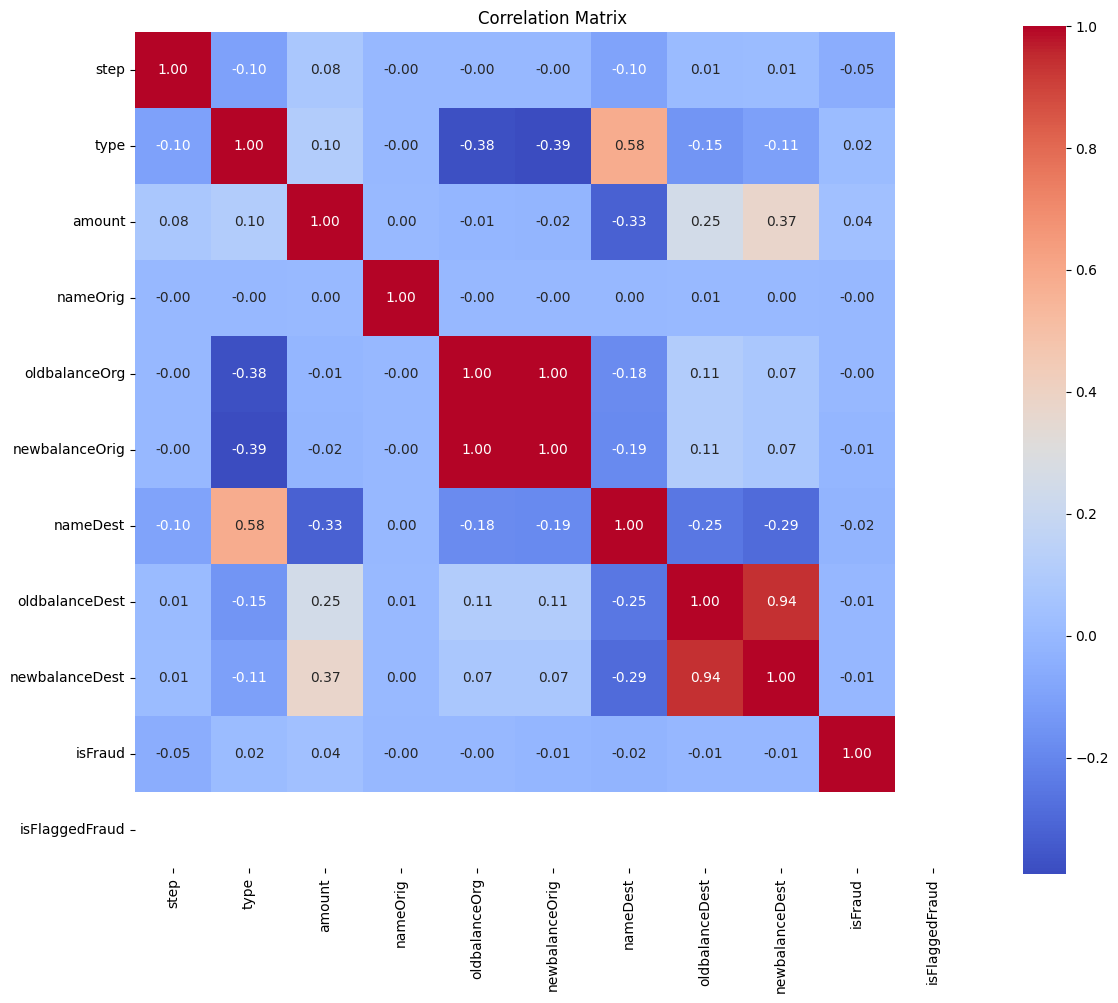

isFraud           1.000000
amount            0.036422
type              0.015555
nameOrig         -0.003244
oldbalanceOrg    -0.004144
newbalanceDest   -0.006394
oldbalanceDest   -0.009266
newbalanceOrig   -0.010872
nameDest         -0.022002
step             -0.051329
isFlaggedFraud         NaN
Name: isFraud, dtype: float64


In [5]:
plt.figure(figsize=(12, 10))

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

target_corr = corr_matrix['isFraud'].sort_values(ascending=False)
print(target_corr)

In [26]:
#preprocessing

#drop 'isFraud' from X
X = df.drop('isFraud', axis=1)
y = df['isFraud']

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)


In [7]:
#feature engineering (maybe Ill remove the type and newbalance columns later)

#df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']


In [8]:
# Scaling for unsupervised learning

df_sample = df.sample(100000, random_state=42)

X_scaled = df_sample.drop(columns=['isFraud'])

def Standard_Scaler(df):
    scaler = StandardScaler()
    
    # Fit on data and transform
    df[col_names] = scaler.fit_transform(df[col_names])
    
    return df

col_names = ['type', 'amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X_scaled = Standard_Scaler(X_scaled)

X_scaled.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,balanceDiffDest
75721,0.821874,-1.371043,0.561972,63242.0,-0.327849,-0.193872,780.0,0.596287,0.946715,0.0,1524116.28
80184,0.821874,0.844868,-0.425787,75817.0,-0.328346,-0.329753,34613.0,-0.366533,-0.422519,0.0,0.00
19864,-0.273695,0.844868,-0.497906,96195.0,-0.328039,-0.329753,25395.0,-0.366533,-0.422519,0.0,0.00
76699,0.821874,1.583505,-0.447087,28897.0,-0.326320,-0.329753,6648.0,-0.340171,-0.422519,0.0,-63327.50
92991,0.821874,0.844868,-0.453699,8447.0,-0.265298,-0.274006,41042.0,-0.366533,-0.422519,0.0,0.00


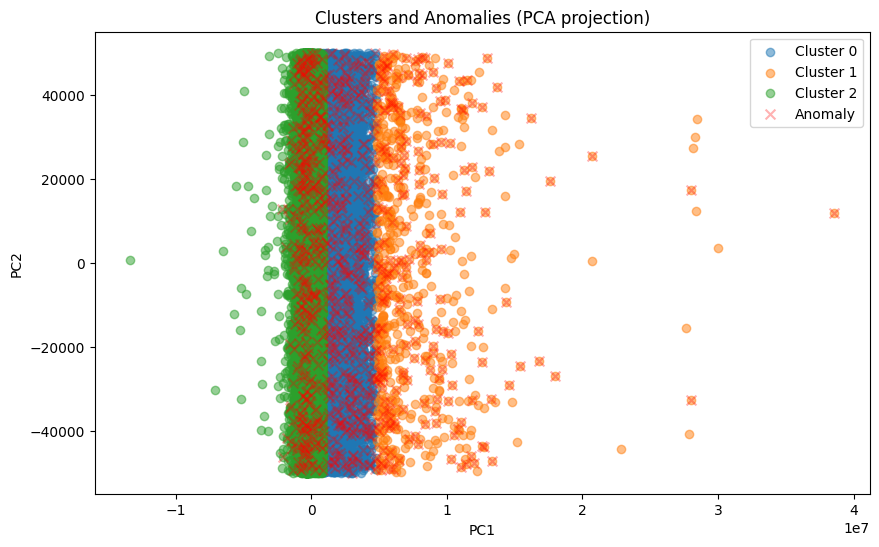

                          PC1           PC2
step             9.120918e-09 -1.100354e-08
type             5.594559e-08 -5.088307e-08
amount           4.622457e-07  2.752004e-08
nameOrig         3.054961e-06  1.000000e+00
oldbalanceOrg   -4.604172e-08 -8.029104e-08
newbalanceOrig  -5.297214e-08 -8.247786e-08
nameDest        -3.140235e-03  5.747354e-05
oldbalanceDest   2.315397e-07  1.787725e-07
newbalanceDest   5.553269e-07  1.532487e-07
isFlaggedFraud   0.000000e+00  0.000000e+00
balanceDiffDest  9.999951e-01 -2.874495e-06


In [9]:
# Unsupervised Learning with KMEans and Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iso = IsolationForest(contamination=0.01, random_state=42)
df_sample['anomaly'] = (iso.fit_predict(X_scaled) == -1).astype(int)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_sample['cluster'] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use cluster color and anomaly shape
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_sample['cluster'].unique()):
    cluster_mask = df_sample['cluster'] == cluster_id
    plt.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.5
    )

# Overlay anomalies (red X markers)
anomalies = df_sample['anomaly'] == 1
plt.scatter(
    X_pca[anomalies, 0],
    X_pca[anomalies, 1],
    color='red', marker='x', label='Anomaly', s=50, alpha=0.3
)

plt.title("Clusters and Anomalies (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

df_show = df_sample.copy()

df_show.groupby('cluster').mean(numeric_only=True)

df_show['PC1'] = X_pca[:, 0]
df_show['PC2'] = X_pca[:, 1]

df_show['anomaly'] = iso.fit_predict(X_scaled)
df_show['anomaly'] = df_show['anomaly'].map({1: 0, -1: 1})

df_show[df_show['anomaly'] == 1].sort_values(by='PC2', ascending=False).head(5)


loadings = pd.DataFrame(pca.components_.T, index=X_scaled.columns, columns=['PC1', 'PC2'])
print(loadings)

In [45]:
# Making sets for supervised learning, using the feature importances and the new cluster column

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X.to_numpy()
y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)


i = y_test[y_test == 1.0].head(1).index[0]
pos_idx = y_test.index.get_loc(i)
print(pos_idx)


# Determine the importance of each feature
#model_xgb = xgb.XGBClassifier(random_state=42)
#model_xgb.fit(X_train, y_train)
#
## Set the figure size before plotting
#plt.figure(figsize=(14, 8))
#xgb.plot_importance(model_xgb, importance_type='weight', max_num_features=12, title='Feature Importances')
#plt.show()

X.head(5)

1201


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,balanceDiffDest
0,1.0,3.0,9839.64,11862.0,170136.0,160296.36,31981.0,0.0,0.0,0.0
1,1.0,3.0,1864.28,34345.0,21249.0,19384.72,33288.0,0.0,0.0,0.0
2,1.0,4.0,181.00,15636.0,181.0,0.00,9303.0,0.0,0.0,0.0
3,1.0,1.0,181.00,91777.0,181.0,0.00,8273.0,21182.0,0.0,-21182.0
4,1.0,3.0,11668.14,54041.0,41554.0,29885.86,16681.0,0.0,0.0,0.0


In [11]:
#training without sampling

from sklearn.metrics import average_precision_score, precision_recall_curve


kf = StratifiedKFold(n_splits=5, shuffle=True)

model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=99.9/1,
    tree_method='hist',
    device = 'cuda',
    eval_metric='logloss',
    #predictor='gpu_predictor',
    random_state=42
)


model.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:, 1]
Y_pred = (y_scores >= 0.8105).astype(int)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

xgb.plot_importance(model, importance_type='gain')

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred))

KeyboardInterrupt: 

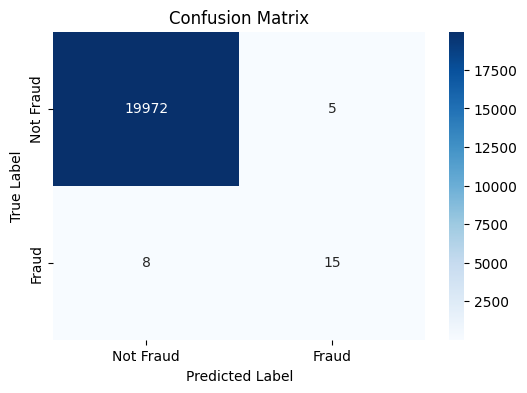

Random Forest Classifier Accuracy: [0.998125  0.9979375 0.9976875 0.998     0.9980625]
Cross Validation Recall scores are: [0.61111111 0.72222222 0.63157895 0.73684211 0.68421053]
Average Cross Validation Recall score: 0.6771929824561403
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     19977
       Fraud       0.75      0.65      0.70        23

    accuracy                           1.00     20000
   macro avg       0.87      0.83      0.85     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
#training with SMOTE (with optimal parameters)

from imblearn.over_sampling import SMOTE

kf = StratifiedKFold(n_splits=5, shuffle=True)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('model', xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    tree_method='hist',
    device = 'cuda',
    eval_metric='aucpr',
    random_state=42,
    subsample=0.8,
    #colsample_bytree=0.8
    ))
])
#the weights should be around 1:6-1:7
#rf = RandomForestClassifier(n_estimators=1000, random_state=13, max_depth=10, class_weight={0: 1, 1: 6})
#rf.fit(X_train_resampled, y_train_resampled)

pipeline.fit(X_train, y_train)
#y_scores = pipeline.predict_proba(X_test)[:, 1]
Y_pred = (y_scores >= 0.7273).astype(int)
#rf.score(X_train, y_train)
#Y_pred = pipeline.predict(X_test)

scoreAcc = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

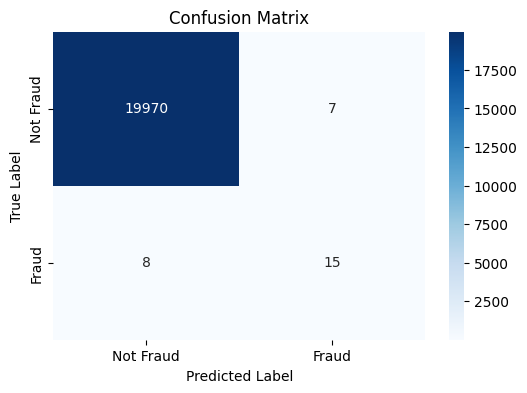

Random Forest Classifier Accuracy: [0.999375  0.99925   0.9993125 0.9994375 0.9990625]
Cross Validation Recall scores are: [0.5        0.5        0.47368421 0.47368421 0.26315789]


In [ ]:
#Ensemble learning

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

kf = StratifiedKFold(n_splits=5, shuffle=True)

smote = SMOTE(random_state=42, sampling_strategy=0.1)

X_train_n, y_train_n = smote.fit_resample(X_train, y_train)

estimators = [
    ('rf', RandomForestClassifier(random_state=13, 
    max_depth = 6, 
    n_estimators = 500, 
    class_weight={0: 1, 1: 6})),
    ('xgb', xgb.XGBClassifier(n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    tree_method='hist',
    device = 'cuda',
    eval_metric='aucpr',
    random_state=42,
    subsample=0.8,
    #colsample_bytree=0.8
    ))
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

stack.fit(X_train_n, y_train_n)

Y_pred = stack.predict(X_test)

#y_scores = pipeline.predict_proba(X_test)[:, 1]
#Y_pred = (y_scores >= 0.9837).astype(int)

scoreAcc = cross_val_score(stack, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(stack, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))

In [ ]:
# # Hyperparameter grid to optimize recall

# from sklearn.metrics import f1_score, make_scorer
# from sklearn.model_selection import GridSearchCV


# pipeline = Pipeline(steps=[
#     ('smote', SMOTE(random_state=13)),
#     ('model', xgb.XGBClassifier(
#     tree_method='hist',
#     device = 'cuda',
#     eval_metric='aucpr',
#     random_state=42
#     ))
# ])

# param_grid = {
#     'model__n_estimators': [100, 300, 500, 1000],
#     'model__max_depth': [3, 6, 10, 12],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
#     'model__subsample': [0.8, 1],
#     'model__colsample_bytree': [0.8, 1],
# }

# f1 = make_scorer(f1_score)

# grid_search = GridSearchCV(pipeline, param_grid, scoring='recall', cv=kf, verbose=2)
# grid_search.fit(X_train, y_train)

# # Best parameters
# print("Best params:", grid_search.best_params_)
# print("Best F1 score:", grid_search.best_score_)
# # Best parameters found: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'n_estimators': 500} n can be more
# # Dont use this for now, it takes too long to run, so only run as one cell
# # for the new one Best 
# # params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 6, 'model__n_estimators': 500, 'model__subsample': 0.8}
# # Best F1 score: 0.9888362221436152


# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)

# scoreAcc = cross_val_score(best_rf, X_train, y_train, cv=kf, scoring='accuracy')
# scoreRe = cross_val_score(best_rf, X_train, y_train, cv=kf, scoring='recall')

# cm = confusion_matrix(y_test, Y_pred)

# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

# print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
# print("Cross Validation Recall scores are: {}".format(scoreRe))
# print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
# print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))


'\nfrom sklearn.metrics import f1_score, make_scorer\nfrom sklearn.model_selection import GridSearchCV\n\n\npipeline = Pipeline(steps=[\n    (\'smote\', SMOTE(random_state=13)),\n    (\'model\', xgb.XGBClassifier(\n    tree_method=\'hist\',\n    device = \'cuda\',\n    eval_metric=\'aucpr\',\n    random_state=42\n    ))\n])\n\nparam_grid = {\n    \'model__n_estimators\': [100, 300, 500, 1000],\n    \'model__max_depth\': [3, 6, 10, 12],\n    \'model__learning_rate\': [0.01, 0.05, 0.1, 0.3],\n    \'model__subsample\': [0.8, 1],\n    \'model__colsample_bytree\': [0.8, 1],\n}\n\nf1 = make_scorer(f1_score)\n\ngrid_search = GridSearchCV(pipeline, param_grid, scoring=\'recall\', cv=kf, verbose=2)\ngrid_search.fit(X_train, y_train)\n\n# Best parameters\nprint("Best params:", grid_search.best_params_)\nprint("Best F1 score:", grid_search.best_score_)\n# Best parameters found: {\'class_weight\': {0: 1, 1: 10}, \'max_depth\': 10, \'n_estimators\': 500} n can be more\n# Dont use this for now, it t

In [ ]:
#Usage of recall curve to get optimal treshold

import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve


kf = StratifiedKFold(n_splits=5, shuffle=False)

#model = xgb.XGBClassifier(
#    n_estimators=500,
#    max_depth=10,
#    learning_rate=0.1,
#    scale_pos_weight=99/1,
#    tree_method='hist',
#    device = 'cuda',
#    eval_metric='logloss',
#    random_state=42
#)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('model', xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.01,
    #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    tree_method='hist',
    device = 'cuda',
    eval_metric='aucpr',
    random_state=42,
    #subsample=0.8,
    #colsample_bytree=0.8
    ))
])

pipeline.fit(X_train, y_train)
Y_pred = pipeline.predict(X_test)
#rf.score(X_train, y_train)

y_scores = pipeline.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
#combined_scores = 0.5 * f1_scores + 0.5 * recalls

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best F1 score: {best_f1:.4f} at threshold: {best_threshold:.4f}")
print(f"F1 score: {f1_scores[best_index]:.4f}")
print(f"Recall: {recalls[best_index]:.4f}")

Best F1 score: 0.7273 at threshold: 0.6741
F1 score: 0.7273
Recall: 0.6957
